## Access Satellite GHRSST L4 Ramssa 1Day Multi Sensor Australia data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia dataset available as a [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/a4170ca8-0942-4d13-bdb8-ad4718ce14bb).

In [1]:
dataset_name = "satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 39ms


In [4]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [5]:
from DataQuery import plot_gridded_variable, create_timeseries, plot_time_coverage

In [6]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 367GB
Dimensions:           (time: 6801, lat: 1081, lon: 1561)
Coordinates:
  * lat               (lat) float32 4kB -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 6kB 60.0 60.08 60.17 ... 189.8 189.9 190.0
  * time              (time) datetime64[ns] 54kB 2006-06-12T12:00:00 ... 2025...
Data variables:
    analysed_sst      (time, lat, lon) float64 92GB dask.array<chunksize=(3, 360, 720), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 92GB dask.array<chunksize=(3, 360, 720), meta=np.ndarray>
    crs               (time) int32 27kB dask.array<chunksize=(3,), meta=np.ndarray>
    filename          (time) <U69 2MB dask.array<chunksize=(3,), meta=np.ndarray>
    mask              (time, lat, lon) float64 92GB dask.array<chunksize=(3, 360, 720), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 92GB dask.array<chunksize=(3, 360, 720), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Link:              https://podaac.jpl.nasa.gov/ws/metadata/datas...
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              Grid
    comment:                    This is a Bureau of Meteorology experimental ...
    contributor_name:           Helen Beggs
    ...                         ...
    time_coverage_end:          20250102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20250101T000000Z
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    uuid:                       3b0fe54a-a41b-44b4-bf0e-fad601580d2f
    westernmost_longitude:      0.0

## Plot time coverage

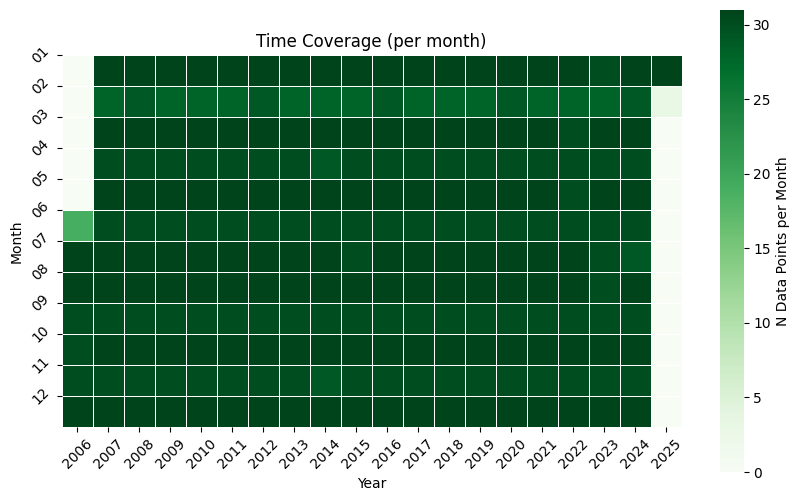

In [7]:
plot_time_coverage(ds)

## Timeseries at a point

In [8]:
%%time
time_series_df = create_timeseries(ds, 'analysed_sst', lat=-40, lon=130, start_time='2025-01-01', end_time='2025-02-18')

ValueError: End time 2025-02-18 00:00:00 is out of bounds. Dataset time extent is (2006-06-12 12:00:00, 2025-02-03 12:00:00)

## Plot a gridded variable

In [ ]:
plot_gridded_variable(ds, start_date='2008-06-01', lon_slice=(120, 150), lat_slice=(-50, -30), var_name='analysed_sst', n_days=6, coastline_resolution="50m")

In [ ]:
plot_gridded_variable(ds, start_date='2008-01-26', lon_slice=(110, 113), lat_slice=(-68, -65), var_name='analysed_sst', n_days=9, coastline_resolution="10m")

## Sea Ice Fraction

In [ ]:
plot_gridded_variable(ds, start_date='2008-01-26', lon_slice=(110, 113), lat_slice=(-68, -65), var_name='sea_ice_fraction', n_days=9, coastline_resolution="10m")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

def daily_avg_sea_ice_fraction(ds, lon_slice, lat_slice, start_date=None, end_date=None, var_name='sea_ice_fraction'):
    """
    Computes and plots the daily average of sea_ice_fraction over a given region (lon_slice, lat_slice)
    for a specified time range, bounded by dataset limits if necessary.

    Parameters:
    - ds: xarray.Dataset containing the sea ice data.
    - lon_slice: tuple, longitude slice (start_lon, end_lon). (min val, max val)
    - lat_slice: tuple, latitude slice (start_lat, end_lat). (min val, max val)
    - start_date: str, start date in 'YYYY-MM-DD' format (optional).
    - end_date: str, end date in 'YYYY-MM-DD' format (optional).
    - var_name: str, variable name to calculate the average for (default is 'sea_ice_fraction').

    Returns:
    - xarray.Dataset containing the daily average of sea_ice_fraction for the specified region and time period.
    """

    ds = ds.sortby('time')

    # Decide on the slice order
    if ds.lat[0] < ds.lat[-1]:
        lat_slice = lat_slice
    elif ds.lat[0] > ds.lat[-1]:  
        lat_slice = lat_slice[::-1]

    # Ensure the dataset has a time dimension
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"

    # Determine the dataset's time range
    dataset_start = pd.to_datetime(ds.time.min().values)
    dataset_end = pd.to_datetime(ds.time.max().values)

    # Parse the start and end dates, default to dataset limits if necessary
    start_date = pd.to_datetime(start_date) if start_date else dataset_start
    end_date = pd.to_datetime(end_date) if end_date else dataset_end

    # Bound the start and end dates within the dataset's time range
    if start_date < dataset_start:
        start_date = dataset_start
    if end_date > dataset_end:
        end_date = dataset_end

    # Select the time range and area
    selected_data = ds.sel(
        lon=slice(lon_slice[0], lon_slice[1]),
        lat=slice(lat_slice[0], lat_slice[1]),
        time=slice(start_date, end_date)
    )

    # Create a mask for valid grid points (open sea or sea ice)
    valid_mask = (selected_data['mask'] == 1) | (selected_data['mask'] == 4)

    # Calculate the daily average over the filtered area using the valid mask
    daily_avg = selected_data[var_name].where(valid_mask).mean(dim=['lon', 'lat']).resample(time='1D').mean()


    # Calculate percentage of non-NaN values
    valid_data_count = valid_mask.count(dim=['lon', 'lat']).resample(time='1D').sum()
    total_data_count = selected_data['mask'].count(dim=['lon', 'lat']).resample(time='1D').sum()
    percentage_valid = (valid_data_count / total_data_count) * 100

    # Plot the time series of daily average sea_ice_fraction
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot daily average sea ice fraction
    daily_avg.plot(ax=ax1, color='blue', marker='o', linestyle='-', label='Daily Avg Sea Ice Fraction')
    ax1.set_ylabel(f"{ds[var_name].attrs.get('units', 'unitless')} (%)")
    ax1.set_title(f"Daily Average {ds[var_name].attrs.get('long_name', var_name)} ({start_date.date()} to {end_date.date()})")
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    ax1.grid(True)

    # Create a second y-axis to plot percentage of valid data
    ax2 = ax1.twinx()
    percentage_valid.plot(ax=ax2, color='orange', marker='x', linestyle='-', label='Percentage of Measured Data Points in Grid')
    ax2.set_ylabel("Percentage of Measured Data Points in Grid (%)")
    ax2.set_ylim(0, 100)  # Set limits for the percentage axis

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.show()

    # Return the daily average as an xarray.Dataset
    return daily_avg.to_dataset(name=f'daily_avg_{var_name}')

In [ ]:
result_ds = daily_avg_sea_ice_fraction(ds, lon_slice=(110, 113), lat_slice=(-68, -65), start_date='2008-01-26',  end_date='2008-02-20', var_name='sea_ice_fraction')